# Real Time Style Transfer

based on paper by [Justin Johnson, et al](https://cs.stanford.edu/people/jcjohns/eccv16/)

## TODOS:
1. Create keras.Layers class instead of functions
2. Search for style images

### List of style images
1. starry night
2. hockney
3. monet
4. rain princess
5. the scream
6. udnie


In [1]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Activation, add, BatchNormalization
import matplotlib.pyplot as plt

tf.enable_eager_execution()

In [2]:
def reflection_padding():
    """Reflection padding layer for output size to match the input size"""
    def f(inputs):
        return tf.pad(inputs, [[0, 0], [40, 40], [40, 40], [0, 0]], "REFLECT")
    return f

def conv_layer(n_channels, kernel_size, strides, padding="same", relu=True):
    """Convolutional layer wrapper"""
    def f(inputs):
        conv = Conv2D(filters=n_channels, kernel_size=kernel_size, strides=strides, padding=padding)(inputs)
        bn = BatchNormalization()(conv)
        if relu:
            return Activation("relu")(bn)
        else:
            return bn
        
    return f

def conv_transpose_layer(n_channels, kernel_size, strides, padding="same", relu=True):
    """Convolutional transpose layer to upsample the image"""
    def f(inputs):
        conv = Conv2DTranspose(n_channels, kernel_size=kernel_size, strides=strides, padding=padding)(inputs)
        bn = BatchNormalization()(conv)
        if relu:
            return Activation("relu")(bn)
        else:
            return bn
        
    return f

def residual_block(n_channels, kernel_size=3, strides=1, padding='valid'):
    """Residual Block. Center cropped the input to match output size"""
    def f(inputs):
        inputs_shape = inputs.get_shape().as_list()
        residual = tf.image.resize_image_with_crop_or_pad(inputs, inputs_shape[1] - 4, inputs_shape[2] - 4)
        conv_1 = Conv2D(filters=n_channels, kernel_size=kernel_size, 
                      strides=strides, padding=padding)(inputs)
        bn_1 = BatchNormalization()(conv_1)
        relu_1 = Activation("relu")(bn_1)
        conv_2 = Conv2D(filters=n_channels, kernel_size=kernel_size, 
                      strides=strides, padding=padding)(relu_1)
        bn_2 = BatchNormalization()(conv_2)
        return add([bn_2, residual])

    return f

In [30]:
class StyleTransferModel(tf.keras.Model):
    """Style Transfer Model class"""
    def __init__(self):
        super(StyleTransferModel, self).__init__(name='style_transfer_model')
        
        # Layers
        self.pad = reflection_padding()
        self.conv_1 = conv_layer(32, 9, 1)
        self.conv_2 = conv_layer(64, 3, 2)
        self.conv_3 = conv_layer(128, 3, 2)
        self.res_1 = residual_block(128, 3, 1)
        self.res_2 = residual_block(128, 3, 1)
        self.res_3 = residual_block(128, 3, 1)
        self.res_4 = residual_block(128, 3, 1)
        self.res_5 = residual_block(128, 3, 1)
        self.conv_4 = conv_transpose_layer(64, 3, 2)
        self.conv_5 = conv_transpose_layer(32, 3, 2)
        self.conv_6 = conv_layer(3, 9, 1, relu=False)


        
    def call(self, inputs):
        # (width x height x channels)
        # 256 x 256 x 3

        # 336 x 336 x 3
        padded = self.pad(inputs)
        # 336 x 336 x 32
        conv_1_out = self.conv_1(padded)
        # 168 x 64 x 64
        conv_2_out = self.conv_2(conv_1_out)
        # 84 x 84 x 128
        conv_3_out = self.conv_3(conv_2_out)
        # 80 x 80 x 128
        res_1_out = self.res_1(conv_3_out)
        # 76 x 76 x 128
        res_2_out = self.res_2(res_1_out)
        # 72 x 72 x 128
        res_3_out = self.res_3(res_2_out)
        # 68 x 68 x 128
        res_4_out = self.res_4(res_3_out)
        # 64 x 64 x 128
        res_5_out = self.res_5(res_4_out)
        # 128 x 128 x 64
        conv_4_out = self.conv_4(res_5_out)
        # 256 x 256 x 32
        conv_5_out = self.conv_5(conv_4_out)
        # 256 x 256 x 3
        conv_6_out = self.conv_6(conv_5_out)
        
        tanh_out = (conv_6_out + 1) * 255. / 2
        return tanh_out

In [26]:
net = StyleTransferModel()

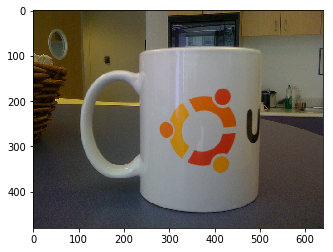

<tf.Tensor: id=4524, shape=(4,), dtype=int32, numpy=array([  1, 480, 640,   3], dtype=int32)>

In [27]:
from keras.preprocessing.image import load_img, img_to_array
content_image = load_img("images/content/mug.jpg")
content_image = img_to_array(content_image)
plt.imshow(content_image/255.)
plt.show()
content_image = content_image.reshape((1, content_image.shape[0], content_image.shape[1], content_image.shape[2]))
content_image = preprocess_input(content_image)
content_image = tf.convert_to_tensor(content_image)
tf.shape(content_image)

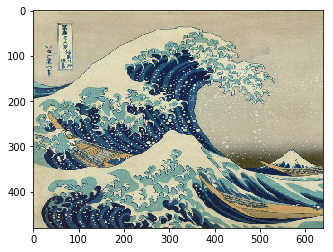

<tf.Tensor: id=4527, shape=(4,), dtype=int32, numpy=array([  1, 480, 640,   3], dtype=int32)>

In [28]:
style_image = load_img("images/styles/wave_crop.jpg", target_size=(480, 640))
style_image = img_to_array(style_image)
plt.imshow(style_image/255.)
plt.show()
style_image = style_image.reshape((1, style_image.shape[0], style_image.shape[1], style_image.shape[2]))
style_image = preprocess_input(style_image)
style_image = tf.convert_to_tensor(style_image)
tf.shape(style_image)

In [29]:
y_hat = net(content_image)

<dtype: 'float32'>


In [31]:
y_hat.dtype

tf.float32

In [21]:
def get_style_features(model, image):
    """ Run an image forward through a model and get the features for 
        a set of style layers.
        Returns a dictionary of the layer name and the activations.
    """
    style_layers = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3']
    
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for layer in model.layers:
        x = layer(x)
        if layer.name in style_layers:
            features[layer.name] = x
            if layer.name == 'block4_conv3':
                break
            
    return features

def get_content_feature(model, image):
    """ Run an image forward through a model and get the features for 
        a set of conent layers.
        Returns the activation of the content layer
    """
    style_layers = ['block3_conv3']
    
    x = image
    # model._modules is a dictionary holding each module in the model
    for layer in model.layers:
        x = layer(x)
        if layer.name in style_layers:
            features = x
            break
            
    return features

In [35]:
def gram_matrix(x):
    """ Compute gram matrix of a 3 dimensional convolution
    """
    b, h, w, c = tf.shape(x)
    x = tf.reshape(x, [b, c, -1])
    size = tf.to_float(c * h * w)
    return  tf.matmul(x, tf.transpose(x, perm=[0, 2, 1])) / size

In [52]:
def loss(y, content_image, style_image, content_weight, style_weight):
    """ Compute loss of output with respect to content and style image
    """
    # Pretrained VGG16 on imagenet
    model = VGG16()
    
    # Style features of output
    output_style_features = get_style_features(model, y)
    # Content features of output
    output_content_feature = get_content_feature(model, y)
    
    # Style features of style image
    style_features = get_style_features(model, style_image)
    # Content features of content image
    content_feature = get_content_feature(model, content_image)
    
    # Compute content loss
    # (output - content )/(Cj * Hj * Wj)
    content_loss = content_weight * tf.reduce_sum(tf.reduce_mean(tf.math.square(output_content_feature - content_feature), 1))
    
    # Compute style loss
    # Gram matrix of output features
    output_grams = [gram_matrix(x) for _, x in output_style_features.items()]
                                                  
    # Gram matrix of style features
    style_grams = [gram_matrix(x) for _, x in style_features.items()]
                                       
    print(tf.shape(output_grams[0]))
    print(tf.shape(tf.norm(output_grams[0] - style_grams[0])))
    style_losses = [tf.square(tf.norm(output_gram - style_gram, axis=(1, 2))) for output_gram, style_gram in zip(output_grams, style_grams)]
    style_loss = tf.reduce_sum(tf.convert_to_tensor(style_losses))
                                                  
    # TODO: Add total variation regularization
    
    total_loss = content_weight * content_loss + style_weight * style_loss
    return total_loss

In [53]:
loss(y_hat, content_image, style_image, 1, 0.001)

tf.Tensor([ 1 64 64], shape=(3,), dtype=int32)
tf.Tensor([], shape=(0,), dtype=int32)


<tf.Tensor: id=14324, shape=(), dtype=float32, numpy=4519431000000.0>

In [ ]:
<tf.Tensor: id=12538, shape=(), dtype=float32, numpy=2355534000000.0>